In [ ]:
from flash_ansr import FlashANSRDataset, get_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/home/psaegert/miniconda3/envs/nsr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = 'v5.8'

In [3]:
dataset = FlashANSRDataset.from_config(get_path('configs', MODEL, 'dataset_train.yaml'))

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 31634.52it/s]


In [4]:
N_SAMPLES = 10_000

In [5]:
data_raw = [d for d in dataset.iterate(size=N_SAMPLES, verbose=True)]

Generating data: 100%|██████████| 10000/10000 [00:20<00:00, 484.14it/s, reject_rate=47.50%]


In [6]:
data = {k: [d[k] for d in data_raw] for k in data_raw[0].keys()}

In [7]:
data.keys()

dict_keys(['n_rejected', 'skeletons', 'expressions', 'constants', 'input_ids', 'x_tensors', 'y_tensors'])

In [8]:
data['skeletons'] = [[str(token) for token in d] for d in data['skeletons']]
data['expressions'] = [[str(token) for token in d] for d in data['expressions']]
data['constants'] = [[float(constant) for constant in d] for d in data['constants']]
data['lengths'] = np.array([len(s) for s in data['skeletons']])
data['n_support'] = np.array([len(s) for s in data['x_tensors']])
data['all_x'] = np.array([x.item() for x_tensor in tqdm(data['x_tensors']) for x in x_tensor.flatten()])
data['all_x'] = data['all_x'][data['all_x'] != 0]
data['all_y'] = np.array([y.item() for y_tensor in tqdm(data['y_tensors']) for y in y_tensor.flatten()])
data['all_constants'] = np.array([c for constants in tqdm(data['constants']) for c in constants])

100%|██████████| 10000/10000 [00:00<00:00, 9283541.39it/s]


In [43]:
def format_int(x):
    if x < 1_000:
        return int(x)
    elif x < 1_000_000:
        return f'{int(x // 1_000)}k'
    else:
        return f'{int(x // 1_000_000)}M'

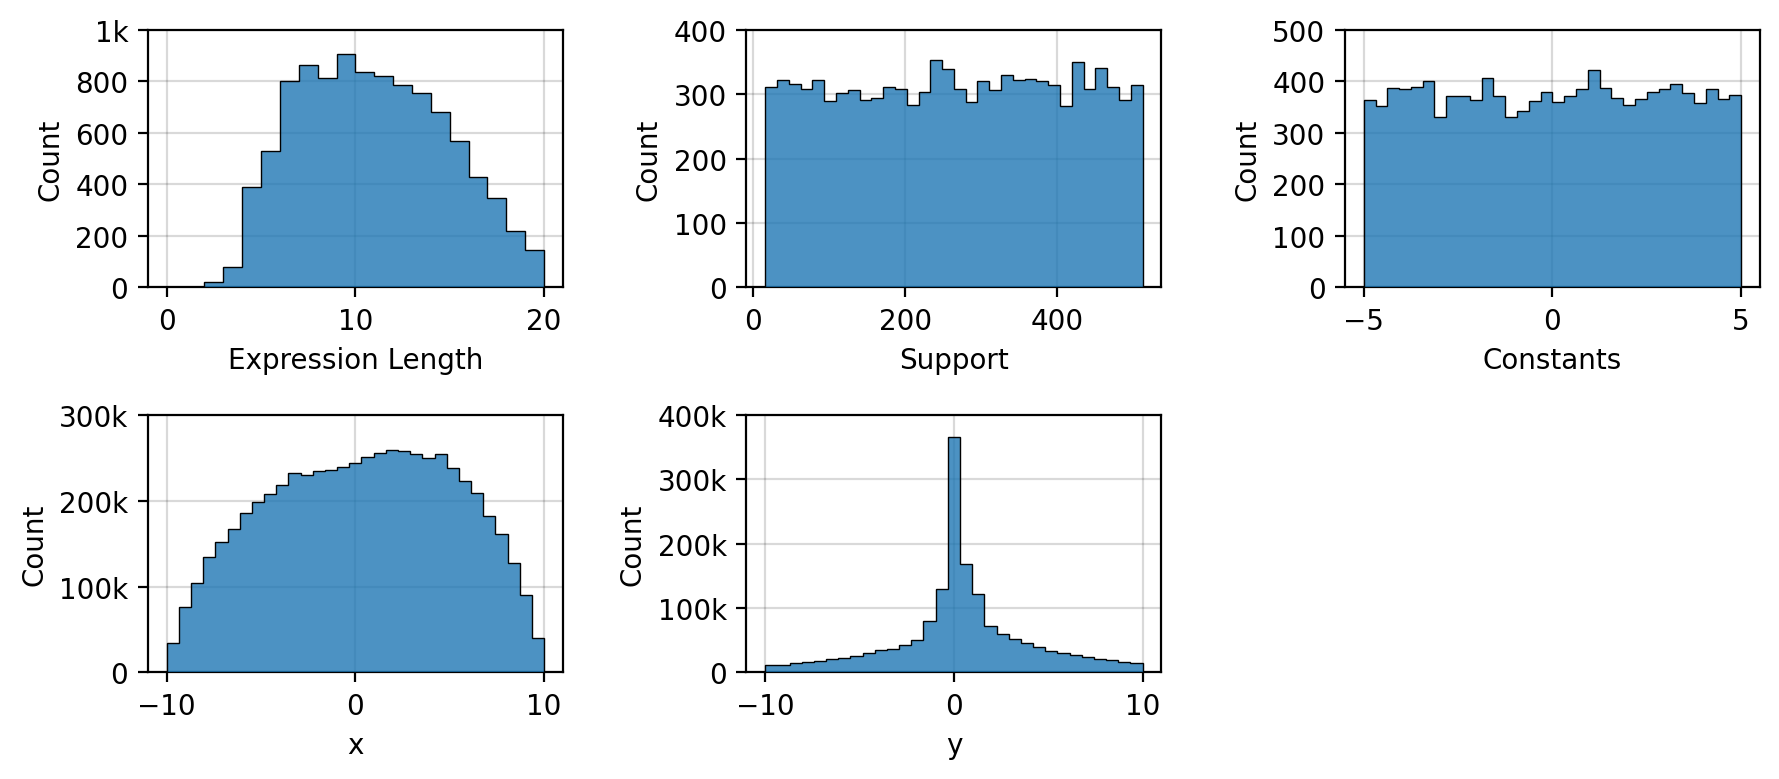

In [52]:
histogram_keys = ['lengths', 'n_support', 'all_constants', 'all_x', 'all_y']
color_list = ['blue', 'red2', 'green3', 'orange3', 'pink2']
titles = ['Expression Length', 'Support', 'Constants', 'x', 'y']
bins_list = [np.arange(0, data['lengths'].max()), 32, 32, np.linspace(-10, 10, 32), np.linspace(-10, 10, 32)]

COLS = min(3, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2), dpi=200)

for ax, k, bins, title, c in zip(axes.flatten(), histogram_keys, bins_list, titles, color_list):
    ax.hist(data[k], bins=bins, zorder=4, alpha=0.8)
    ax.hist(data[k], bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5)
    ax.set_xlabel(title)
    ax.set_ylabel('Count')
    ax.grid(alpha=0.15, color='k')
    # ax.set_xticks(np.arange(0, 20, 5));

    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([format_int(y) for y in ax.get_yticks()])

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=2)